In [50]:
# Import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA

### Wrangle Data

In [2]:
# Load features and target datasets

df_features = pd.read_csv('train_features.csv', index_col=0)
df_targets = pd.read_csv('train_targets_scored.csv', index_col=0)

# Print the shapes
df_features.shape, df_targets.shape

((23814, 875), (23814, 206))

In [3]:
# Take a look at the df_features
df_features.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


**Takeaways**
- Drop the categorical variables. (A common misake new data scientists make is to apply PCA to non-continous variables.)
- Scale the continuous variables by StandardScaler

In [4]:
# Drop the categoricals
df_features.drop(columns=['cp_type', 'cp_time', 'cp_dose'], inplace=True)
df_features.shape # 872 features left

(23814, 872)

In [5]:
# Scale the features so each feature has unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Print the data type of X_scaled
type(X_scaled) # the scaler returns a np.array

numpy.ndarray

In [6]:
# Length of the array should match the number of observations
len(X_scaled) # 23814, matched

23814

In [7]:
# The length of every member in the array shoulb math the number of the features
len(X_scaled[0]) # 872, matched

872

In [9]:
# Check the mean of the scaled dataset
X_scaled.mean(axis=0)[:5] # checked: the scaled data have a mean of ~0

array([-8.95115565e-18,  2.02892861e-17,  2.83453262e-17, -6.86255267e-18,
       -4.77394968e-18])

In [10]:
# Checkt the variance of the scaled dataset
X_scaled.var(axis=0)[:5] # Checked: should be 1 from begining to the end

array([1., 1., 1., 1., 1.])

### Principal Component Analysis
- **Linear dimensionality** reduction using **Singular Value Decomposition of the data** to project it to a lower dimensional space. 
- The **input data is centered but not scaled** for each features before applying the SVD. 
- Notice that this class **does NOT support sparse input.**

In [11]:
# Create a PCA object
pca = PCA(n_components=10)
pca

PCA(n_components=10)

In [12]:
# Transform the scaled data
X_pca = pca.fit_transform(X_scaled)

# Check the shape of X_pca
X_pca.shape

(23814, 10)

In [27]:
# Prepare the data for visualization

# Convert X_pca to dataframe
df_pca = pd.DataFrame(X_pca)

# Take the labels from the matrix
nfkb = df_targets.loc[:, 'nfkb_inhibitor']
cyclo = df_targets.loc[:, 'cyclooxygenase_inhibitor']

# Concat the target columns
df_pca['nfkb'] = nfkb.values
df_pca['cyclo'] = cyclo.values

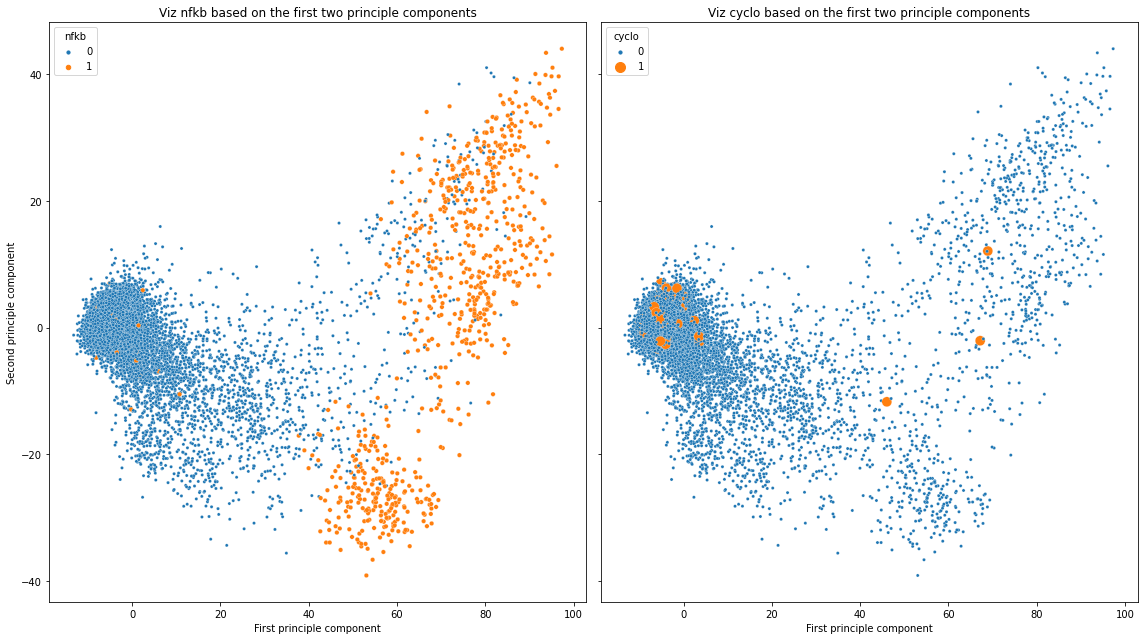

In [35]:
# Viz

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_pca, x=df_pca[0], y=df_pca[1], 
                hue='nfkb', size='nfkb', sizes=(20, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_pca, x=df_pca[0], y=df_pca[1], hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()

### Incremental PCA
- **Linear dimensionality** reduction using **Singular Value Decomposition of the data**.
- To keep only the most significant singular vectors to project the data to a lower dimentional space. 
- The input the data is centered but not scaled for each feature before applying the SVD. 

In [37]:
# Create the object
ipca = IncrementalPCA(n_components=10)
ipca

IncrementalPCA(n_components=10)

In [39]:
# Fit and transform the scaled data
X_ipca = ipca.fit_transform(X_scaled)

# Print the shape
X_ipca.shape

(23814, 10)

In [40]:
# Prepare the data for visualization

# Convert X_pca to dataframe
df_ipca = pd.DataFrame(X_ipca)

# Take the labels from the matrix
nfkb = df_targets.loc[:, 'nfkb_inhibitor']
cyclo = df_targets.loc[:, 'cyclooxygenase_inhibitor']

# Add the target columns
df_ipca['nfkb'] = nfkb.values
df_ipca['cyclo'] = cyclo.values

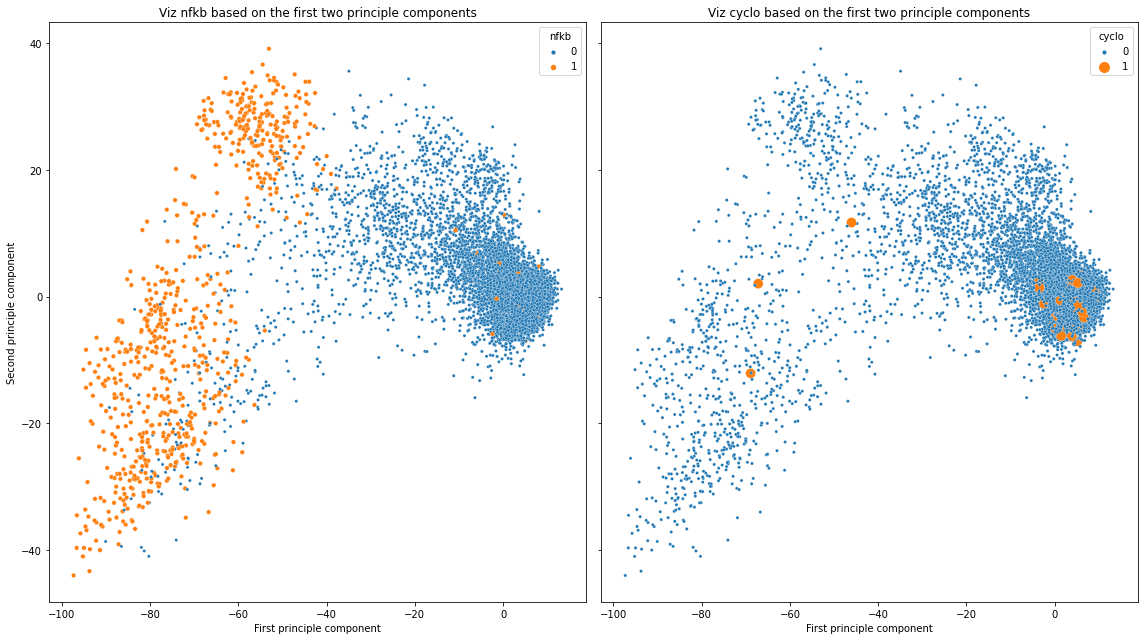

In [41]:
# Viz

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_ipca, x=df_ipca[0], y=df_ipca[1], 
                hue='nfkb', size='nfkb', sizes=(20, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_ipca, x=df_ipca[0], y=df_ipca[1], 
                hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()

### Kernel PCA
- **Non-linear dimensionality reduction** through the use of kernels.

In [44]:
# Create the object
kpca = KernelPCA(n_components=5, kernel='rbf')

# Print the object
kpca

KernelPCA(kernel='rbf', n_components=5)

In [45]:
# Fit and transform the scaled data
X_kpca = kpca.fit_transform(X_scaled) # Took 2 mins

# Print the shape
X_kpca.shape

(23814, 5)

In [46]:
# Print attributes
kpca.lambdas_

array([1073.51645672,  400.7973264 ,  342.95753182,  266.52206607,
        168.15217308])

In [47]:
# Prepare the data for visualization

# Convert X_pca to dataframe
df_kpca = pd.DataFrame(X_kpca)

# Take the labels from the matrix
nfkb = df_targets.loc[:, 'nfkb_inhibitor']
cyclo = df_targets.loc[:, 'cyclooxygenase_inhibitor']

# Add the target columns
df_kpca['nfkb'] = nfkb.values
df_kpca['cyclo'] = cyclo.values

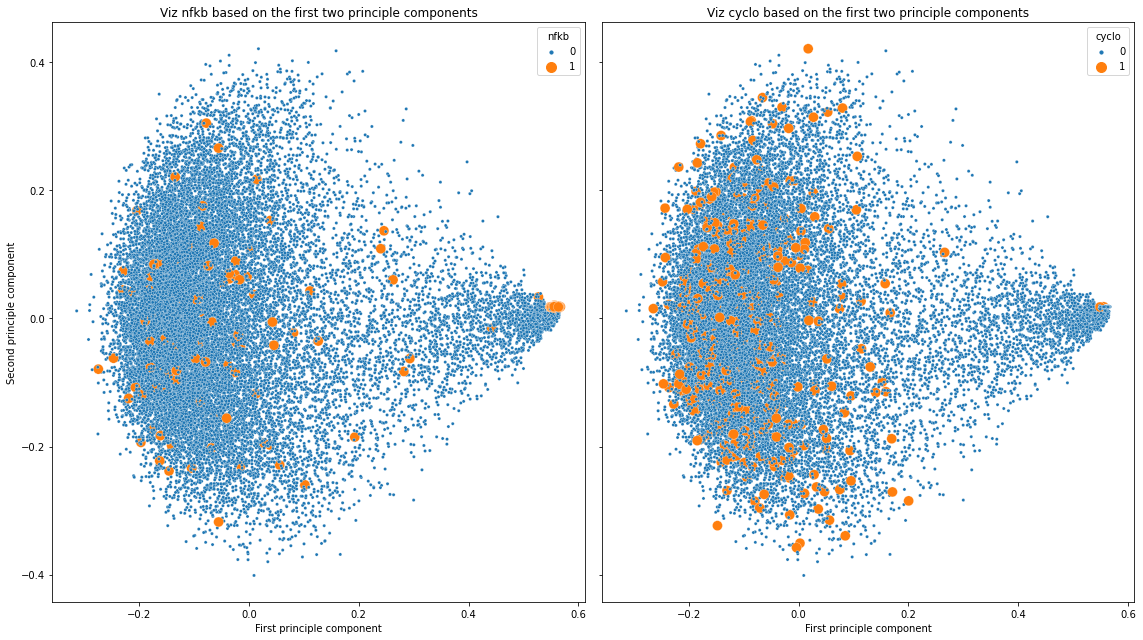

In [49]:
# Viz

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_kpca, x=df_kpca[0], y=df_kpca[1], 
                hue='nfkb', size='nfkb', sizes=(100, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_kpca, x=df_kpca[0], y=df_kpca[1], 
                hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()

### Sparse PCA
- A particular disavdantage of ordinary PCA is that the principal components are usually linear combination of all input variables.
- Sparse PCA overcomes this by finding linear combinations that contain just a new input variables.
- **alpha**: sparsity controlling parameter. Higher values lead to sparser components.

In [51]:
# Create the object
spca = SparsePCA(n_components=5, alpha=1) 

# Print the object
spca

SparsePCA(n_components=5)

In [52]:
# Fit and transform the scaled data
X_spca = spca.fit_transform(X_scaled) # Took 14 mins

# Print the shape
X_spca.shape

(23814, 5)

In [53]:
# Print the attributes
print(spca.n_components_)

5


In [54]:
# Prepare the data for visualization

# Convert X_pca to dataframe
df_spca = pd.DataFrame(X_spca)

# Take the labels from the matrix
nfkb = df_targets.loc[:, 'nfkb_inhibitor']
cyclo = df_targets.loc[:, 'cyclooxygenase_inhibitor']

# Add the target columns
df_spca['nfkb'] = nfkb.values
df_spca['cyclo'] = cyclo.values

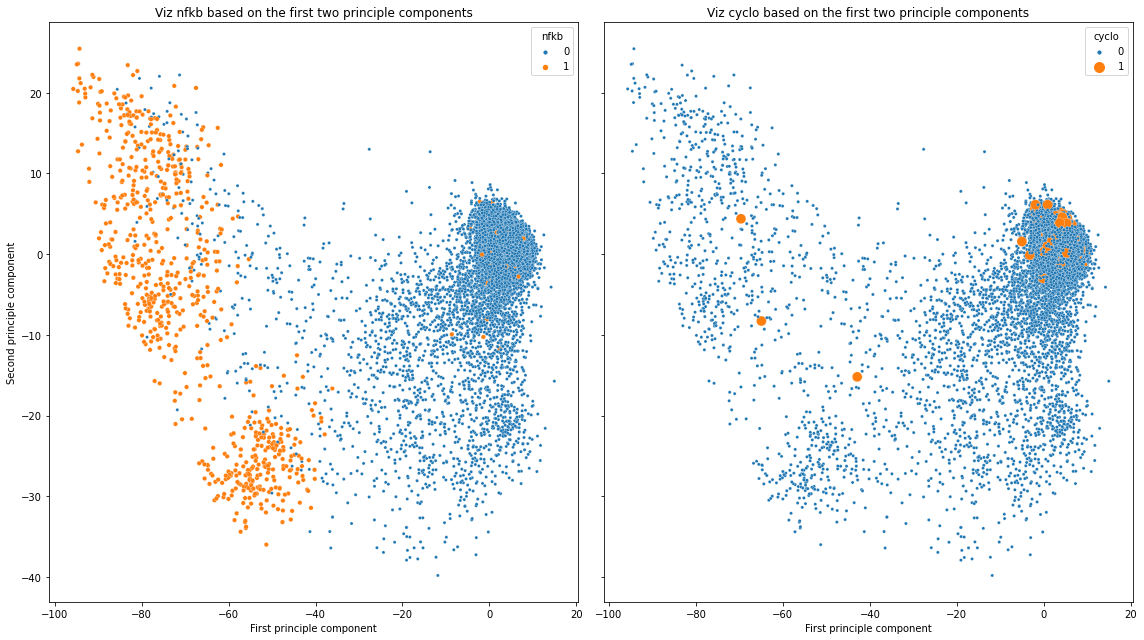

In [56]:
# Viz

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_spca, x=df_spca[0], y=df_spca[1], 
                hue='nfkb', size='nfkb', sizes=(20, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_spca, x=df_spca[0], y=df_spca[1], 
                hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()